In [34]:
#import libraries:
import requests
import json
import pandas as pd
import datetime
import itertools
from itertools import repeat
import matplotlib
import matplotlib.pyplot as pt
from matplotlib import dates as dt
from matplotlib import style
import numpy as np
#print(pt.style.available)
style.use('seaborn-darkgrid')
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [6]:
#Generate list of years of interest:
dates = pd.date_range(start = "01-01-2000", end = "12-31-2020", freq = 'Y')#get years
dates = dates.strftime("%Y")#extract year 
dates = dates.to_list() #put dates into a python list


In [7]:
sample = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate=2020-01-01&enddate=2020-01-04", headers={'token':'sppyRslRxXMETktiexBiKTvMtnkNFfEX'})
sample.json()#example JSON return (for presentation)

{'metadata': {'resultset': {'offset': 1, 'count': 4, 'limit': 1000}},
 'results': [{'date': '2020-01-01T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00040693',
   'attributes': ',,7,0800',
   'value': 62.0},
  {'date': '2020-01-02T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00040693',
   'attributes': ',,7,0800',
   'value': 61.0},
  {'date': '2020-01-03T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00040693',
   'attributes': ',,7,0800',
   'value': 64.0},
  {'date': '2020-01-04T00:00:00',
   'datatype': 'TMAX',
   'station': 'GHCND:USC00040693',
   'attributes': ',,7,0800',
   'value': 61.0}]}

In [8]:
#Call API to gather data from 01-01-2000 to 12-31-2020
Token = 'sppyRslRxXMETktiexBiKTvMtnkNFfEX'#API token
station_id = "GHCND:USC00040693"#station data used for UC Berkeley
#setup lists to store data
date_rain = []
date_tmax = []
date_tmin = []
rain_lst = []
tmin_lst = []
tmax_lst = []
#query API for data of interest:
for i in dates: #loop through list of years and append them to API call where appropriate
    temp_max = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
    rain = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
    temp_min = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})

    #convert to JSON:
    rain = rain.json()
    tmin = temp_min.json()
    tmax = temp_max.json()

    #create dataframe for each API call:
    rain_table = pd.json_normalize(rain["results"])
    tmin_table = pd.json_normalize(tmin["results"])
    tmax_table = pd.json_normalize(tmax["results"])

    #append data to appropriate list in order to construct overall dataset for UC Berkeley:
    date_rain.append(rain_table["date"].tolist())
    rain_lst.append(rain_table["value"].tolist())
    date_tmin.append(tmin_table['date'].tolist())
    tmin_lst.append(tmin_table['value'].tolist())
    date_tmax.append(tmax_table['date'].tolist())
    tmax_lst.append(tmax_table['value'].tolist())

#create dataset with date and value for each paramter of interest:
rain_data = pd.DataFrame({
    "Date":list(itertools.chain.from_iterable(date_rain)),
    "Precip":list(itertools.chain.from_iterable(rain_lst))
})

tmax_data = pd.DataFrame({
    "Date":list(itertools.chain.from_iterable(date_tmax)),
    "tmax":list(itertools.chain.from_iterable(tmax_lst))
})

tmin_data = pd.DataFrame({
    "Date": list(itertools.chain.from_iterable(date_tmin)),
    "tmin":list(itertools.chain.from_iterable(tmin_lst))
})


In [9]:
#clean dates and set indices for merge:

#clean date variable:
rain_data['Date'] = pd.to_datetime(rain_data["Date"]).dt.date
tmax_data["Date"] = pd.to_datetime(tmax_data["Date"]).dt.date
tmin_data["Date"] = pd.to_datetime(tmin_data["Date"]).dt.date

#set date as index for each dataframe:
rain_data = rain_data.set_index("Date")
tmax_data = tmax_data.set_index("Date")
tmin_data = tmin_data.set_index("Date")


In [10]:
#merge datasets into 1 dataset:
berk_dat = tmax_data.merge(tmin_data, how="left",left_index=True, right_index=True)
#berk_dat = berk_dat.merge(rain_data, how = "inner", left_index = True, right_index=True)
berk_dat["average"] = berk_dat["tmin"] + ((berk_dat["tmax"]-berk_dat["tmin"])/2) #compute average temperature
berk_dat["over_100"] = berk_dat["tmax"].apply(lambda x:  1 if x>=100 else 0)#boolean to identify days with high temp 100 degrees or higher
berk_dat = berk_dat.dropna()
berk_dat

,tmax,tmin,average,over_100
Date,,,,
2000-01-01,50.0,45.0,47.5,0
2000-01-02,53.0,40.0,46.5,0
2000-01-03,55.0,42.0,48.5,0
2000-01-04,55.0,42.0,48.5,0
2000-01-05,56.0,40.0,48.0,0
...,...,...,...,...
2020-09-26,80.0,59.0,69.5,0
2020-09-27,87.0,61.0,74.0,0
2020-09-28,97.0,72.0,84.5,0


In [11]:
#compute difference between max and min temperature:
berk_dat["difference"] = berk_dat.eval("tmax - tmin")
berk_dat.head()

,tmax,tmin,average,over_100,difference
Date,,,,,
2000-01-01,50.0,45.0,47.5,0,5.0
2000-01-02,53.0,40.0,46.5,0,13.0
2000-01-03,55.0,42.0,48.5,0,13.0
2000-01-04,55.0,42.0,48.5,0,13.0
2000-01-05,56.0,40.0,48.0,0,16.0


In [12]:
#reset index
mon_df = berk_dat.copy()
mon_df = mon_df.reset_index()
berk_dat = berk_dat.reset_index

In [13]:
#narrow dataset down to monthly time period:
mon_df["Date"] = pd.to_datetime(mon_df["Date"]).dt.strftime("%Y-%m")#drop day from datetime object
mon_df.head()
#mon_df = mon_df.reset_index()

,Date,tmax,tmin,average,over_100,difference
0,2000-01,50.0,45.0,47.5,0,5.0
1,2000-01,53.0,40.0,46.5,0,13.0
2,2000-01,55.0,42.0,48.5,0,13.0
3,2000-01,55.0,42.0,48.5,0,13.0
4,2000-01,56.0,40.0,48.0,0,16.0


In [14]:
#extract year for each date:
year_df = mon_df.copy()
year_df["Date"] = pd.to_datetime(year_df["Date"]).dt.strftime("%Y")#drop month from datetime object
#rain_data = rain_data.reset_index()
#interest = rain_data[rain_data["Date"].astype("str").str.startswith("2011")]
#interest["Date"].value_counts()

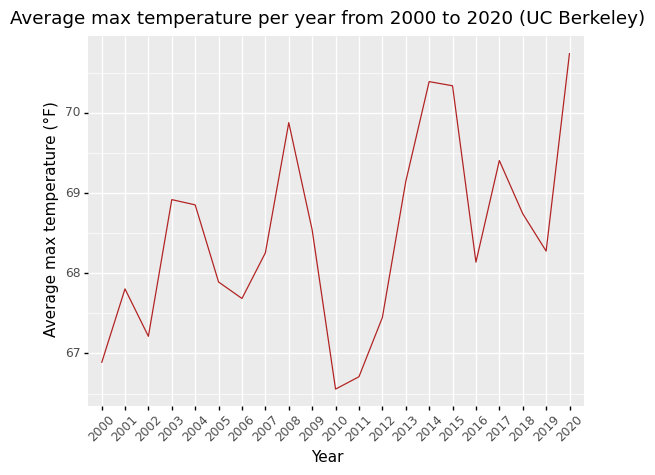

<ggplot: (136007450859)>

In [15]:
#Produce plot of average high temperature over time:
year_df_mean = year_df.groupby(['Date']).mean().reset_index()#average high temp for each year in dataset
p9.ggplot(year_df_mean) + p9.aes(x='Date',y='tmax',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UC Berkeley)")

In the above plot, we can observe that in this 20 year time period, the average high temperature has become higher, with the exception of 2011, which appears to have been an abnormally cold year. However, this observation should be taken with caution, as 2011 in the dataset has roughly half of the observations compared to other years. This anomaly could likely be due to a La-Nina year. A La-Nina weather pattern is typically associated with cooler weather in the eastern pacific, so this could explain the dramatic drop in temperature. For more information, see the link below.

climate.gov/news-features/understanding-climate/double-dip-la-niña

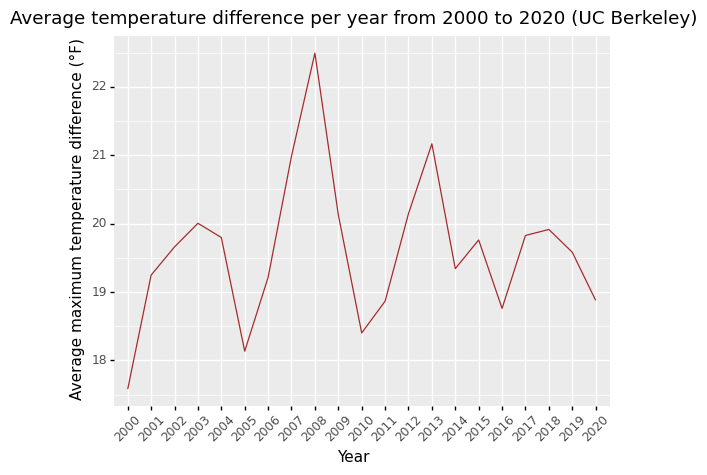

<ggplot: (136013281232)>

In [16]:
#plot of max temperature difference per year:
p9.ggplot(year_df_mean) + p9.aes(x='Date',y='difference',group = 1) + \
p9.geom_line(color='brown') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average maximum temperature difference (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UC Berkeley)")


The above plot shows the average temperature difference between the high and low temperature for each day, averaged for a whole year, over a 20 year time period. This plot is important because it shows how the high and low temperatures have become more extreme in a given year. Notice how the plot appears to have quite a few high points and low points. This tells us that weather patterns in the past 20 years have been quite extreme. This is to be expected, as one of the effects of climate change is more extreme weather.

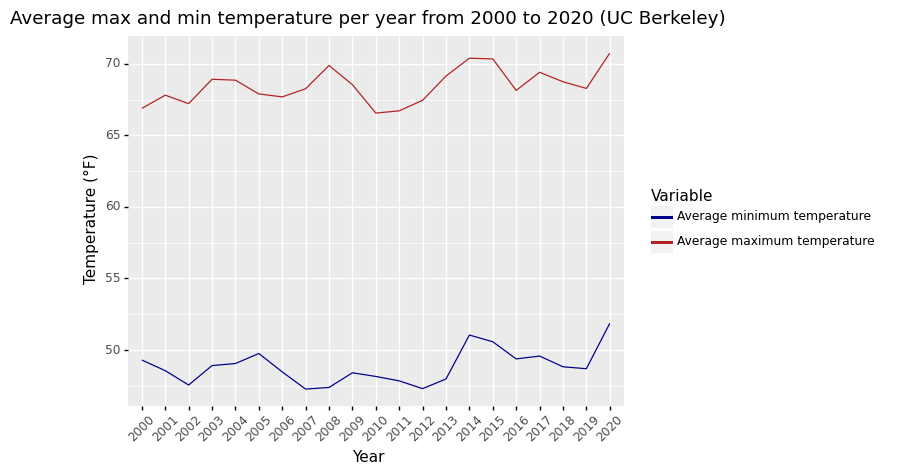

<ggplot: (136013038855)>

In [17]:
#plot of average min and max temperature over time:
p9.ggplot(year_df_mean, p9.aes(x='Date',y='tmin',group = 1)) + \
p9.geom_line(p9.aes(y='tmin', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='tmax', color='"firebrick"')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020 (UC Berkeley)")

The above plot shows the average high and low temperature for a given year on the same plot. We can see that there are no stron trends in either the positive or negative direction, other than normal fluctuations from year to year. This makes sense, because Berkeley is close to the coast of California, and costal areas tend to have relatively constant temperatures throughout the year. When compared to areas that are more inland, such as Davis and Los Angeles, we will see that there are more noticable trends in average temperatures.

Next, we will perform a two-sample t-test to test if the mean high temperature has changed significantly from 2000 to 2020. Specifically, if the mean high temperature in 2020 is greater than that in 2000.

In [35]:
#Perform t-test to test for statistical evidence of difference in means:
year_2000 = year_df.loc[year_df['Date'] == '2000','tmax']
year_2020 = year_df.loc[year_df['Date'] == '2020','tmax']
#print(year_2000.mean())
#print(year_2020.mean())
#Two sample t-test
print(stats.ttest_ind(a=year_2020,b=year_2000,alternative='greater'))
# 95% C.I. for 2000 and 2020
#print(stats.t.interval(alpha=0.95, df=len(year_2000)-1, loc=np.mean(year_2000), scale=stats.sem(year_2000)))
#print(stats.t.interval(alpha=0.95, df=len(year_2020)-1, loc=np.mean(year_2020), scale=stats.sem(year_2020)))

Ttest_indResult(statistic=5.15207120725513, pvalue=1.719322708601919e-07)


The p-value for this test is much smaller than alpha = 0.05, so we would reject the null hypothesis and conclude that there is a statistically significant change in high temperature in the 20 year time period between 2000 and 2020.

Next, we will perform a Kruskal-Wallace test to test if there is a statistically significant difference between the mean high temperatures for all the years in the dataset. We chose to use the Kruskal-Wallace test here because it makes no assumption about the underlying distribution of the data, and since we are not fitting a model for the scope of this project, we do not have a method to evaluate the normality of the data. Therefore, using a t-test would be inappropriate here, since it assumes that the data follows an approximately normal distribution.

In [19]:
#Perform Kruskal-Wallace test to determine if average temperatures over time are different:
grps = [d['tmax'].tolist() for _, d in year_df.groupby('Date')]
print(stats.kruskal(*grps))

KruskalResult(statistic=128.0253701527085, pvalue=9.137767164955718e-18)


This value is quite low, so we reject the null hypothesis at significance level alpha = 0.05, and conclude that the mean high temperature differs between years. Next, we produce a plot to demonstrate this visually.

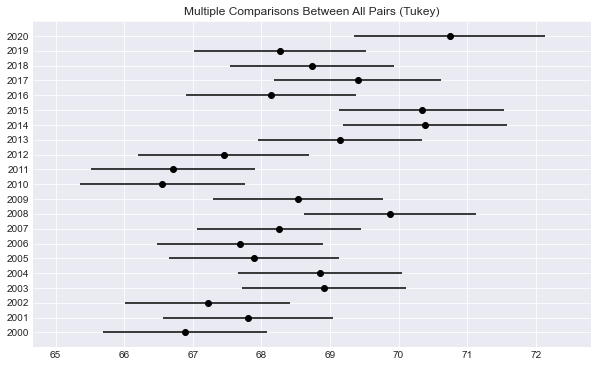

In [33]:
#plot Tukey simultaneous confidence intervals 
tukey = pairwise_tukeyhsd(endog=year_df['tmax'],groups=year_df['Date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()

In [21]:
#reset index on rain dataset:
rain_data = rain_data.reset_index()

In [22]:
#strip day and month from raindata:
rain_data["Date"] = pd.to_datetime(rain_data["Date"]).dt.strftime("%Y")

Now we turn our attention to rainfall. We conduct a Kruskal-Wallace test to determine if mean rainfall differs between years.

In [36]:
#test for differences in mean rainfall per year:
grps = [d['Precip'].tolist() for _, d in rain_data.groupby('Date')]
stats.kruskal(*grps)

KruskalResult(statistic=240.97387752704142, pvalue=7.50397867252399e-40)

The p-value is quite low, so we reject the null hypothesis at significance level alpha = 0.05, and conclude that rainfall differs between years. Below is a plot that visualizes the results of this test for each year.

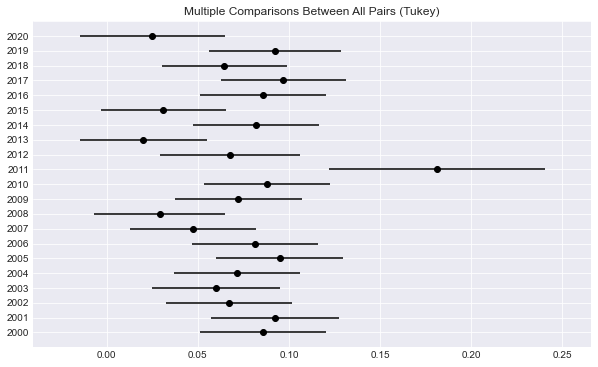

In [32]:
#visualize simultaneous confidence intervals:
tukey = pairwise_tukeyhsd(endog=rain_data['Precip'],groups=rain_data['Date'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()